## 5.1 K-means algorithm

Suppose we are given the following $2$D dataset $\{\mathbf{x}_n\}$, with the goal of grouping the datapoints in clusters:

In [1]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
import sys
sys.path.append('..')
from helper_functions import *
set_notebook_preferences()

x = np.load('clustering_2d.npy')

plt.scatter(x[:, 0], x[:, 1], marker = 'o', color = 'white', edgecolor = 'black')
beautify_plot({"title":"Clustering dataset", "x":"$x_1$", "y":"$x_2$"})
plt.show()

<Figure size 640x480 with 1 Axes>

One way to proceed is the K-means algorithm. We assume there are K clusters centered at $\mathbf{m}_k, k = 1, 2, 3..., K$, and that each datapoint belongs to one of these clusters. Each point's cluster membership is denoted by the 1-of-K indicator $s_{nk}$ where $s_{nk} = 1$ means the $n^{th}$ point belongs to the $k^{th}$ class and $s_{nk} = 0$ means the opposite. The K-means algorithm then tries to cluster the points by minimising the cost function

\begin{align}
\mathcal{C} = \sum_{n = 1}^N \sum_{k = 1}^K s_{nk} \lvert \lvert \mathbf{x}_n - \mathbf{m}_k \rvert \rvert^2
\end{align}

with respect to $s_{nk}$ and $\mathbf{m}_k$. The cost function $\mathcal{C}$ is therefore the sum of squares of the distance of each datapoint from the cluster center to which it belongs: for given $n = n^\star$, the index $s_{n^\star k}$ contains a single $1$ at $k = k^\star$ and all other entries are $0$ for $k \neq k^\star$, the cost $\mathcal{C}$ gets a contribution $\lvert \lvert \mathbf{x}_{n^\star} - \mathbf{m}_{k^\star} \rvert \rvert^2$ from datapoint $n = n^\star$. By varying $s_{nk}$ and $\mathbf{m}_k$ to minimise $\mathcal{C}$, the algorithm effectively reallocates the points and shifts the cluster centers. This is achieved by repeating the two-step process:

1. Minimise $\mathcal{C}$ with respect to $\{s_{nk}\}$ keeping $\{\mathbf{m}_k\}$ fixed.


2. Minimise $\mathcal{C}$ with respect to $\{\mathbf{m}_k\}$ keeping $\{s_{nk}\}$ fixed.

This process is repeated until convergence, i.e. when the $\{s_{nk}\}$ no longer change. For each $n$, the $s_{nk}$ which minimises $\mathcal{C}$ for fixed $\{\mathbf{m}_k\}$ (remembering that $s_{nk}$ is a 1-of-K binary variable) is

\begin{align}
s_{nk} = 1 \text{ for } k = \text{arg } \max_{k} \lvert \lvert \mathbf{x}_n - \mathbf{m}_k \rvert \rvert^2, \text{ and } s_{nk} = 0 \text{ for all other $k$}
\end{align}

The $\{\mathbf{m}_k\}$ which minimises $\mathcal{C}$ for fixed $s_{nk}$ can also be found easily by setting the derivative of $\mathcal{C}$ w.r.t. $\mathbf{m}_k$ equal to $0$:

\begin{align}
\frac{\partial \mathcal{C}}{\partial \mathbf{m}_k} &= \sum_{n = 1}^N s_{nk} (\mathbf{m}_k - \mathbf{x}_n)\\
~\\
&= \sum_{s_{nk} = 1}  (\mathbf{m}_k - \mathbf{x}_n) = 0\\
~\\
\implies \mathbf{m}_k &= \frac{1}{\sum_n s_{nk}}\sum_{s_{nk} = 1}\mathbf{x}_n = \frac{1}{N_k}\sum_{s_{nk} = 1}\mathbf{x}_n\\
\end{align}

where the sum $\sum_{s_{nk} = 1}$ denotes the sum over all datapoints for which $s_{nk} = 1$ for the given $k$, and $N_k = \sum_n s_{nk}$ is the number of datapoints in class $k$. Note also that this solution for $\mathbf{m}_k$ is simply the mean position of the datpoints belonging to that class.

Summarising the optimisation process:

1. Update $s_{nk} = 1 \text{ for } k = \text{arg } \max_{k} \lvert \lvert \mathbf{x}_n - \mathbf{m}_k \rvert \rvert^2, \text{ and } s_{nk} = 0 \text{ for all other $k$}$ keeping $\{\mathbf{m}_k\}$ fixed.

2. Update $\mathbf{m}_k = 1/N_k\sum_{s_{nk} = 1}\mathbf{x}_n$ keeping $\{s_{nk}\}$ fixed.

3. If the updated memberships $\{s_{nk}\}$ are the same as the previous ones, stop. If not repeat from 1.

At this point one could raise several important questions about k-means:

- How do we choose $K$?

- How do we initialise class membership $s_{nk}$?

- Does the k-means algorithm converge or is there a chance it might not for certain datasets and/or initialisations?

- Does the algorithm have a unique (global) maximum or could it converge to a local maximum which is suboptimal?

We defer these questions for later, and assume $K = 3$ (after inspecting the dataset) and a completely random initialisation of class membership and cluster centers.

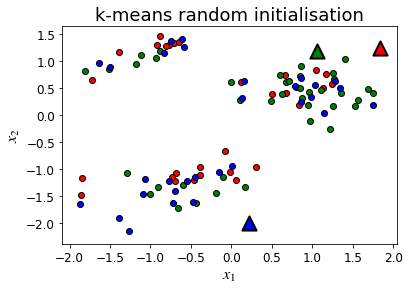

In [2]:
K, N = 3, x.shape[0]

mus = np.random.rand(K, 2)*4 - 2 # initialise cluster centers randomly in [-2, 2]
s = np.zeros(shape = (N, K)) # set all membership indices to 0
memberships = np.random.choice(np.arange(0, K), N) # randomly choose a cluster for each point
s[np.arange(s.shape[0]), memberships] = 1 # set the 1-entries according to the random sample
colors = ['r', 'g', 'b']

for idx, mu in enumerate(mus): # cycle over clusters
    plt.scatter(mu[0], mu[1], marker = '^', color = colors[idx], s = 200,
                edgecolor = 'black', zorder = 2, linewidth = '2') # plot cluster center
    
    points_in_class = x[np.where(s[:, idx] == 1)[0], :] # select points in current cluster ...
    
    plt.scatter(points_in_class[:, 0], points_in_class[:, 1], marker = 'o',
                color = colors[idx], edgecolor = 'black') # ... and plot
beautify_plot({"title":"k-means random initialisation", "x":"$x_1$", "y":"$x_2$"})
plt.show()

As you can see, the initial memberships and cluster centers are completely random, and rerunning this cell will give a different initialisation. Now for the optimisation:

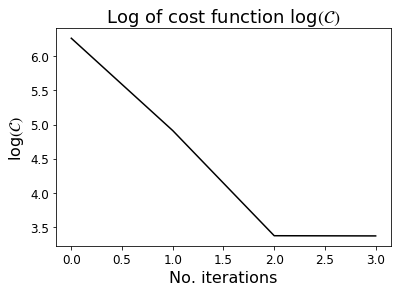

In [3]:
xs = np.stack([x]*K, axis = 1) # stack K copies of x to do calculation for each cluster
costs = [np.sum(s*np.sum((xs - mus)**2, axis = 2))] # array to store costs, containing 1st cost
converged = False

while not(converged):
    
    mus = (s.T).dot(x)/s.sum(axis = 0).reshape((-1, 1)) # compute 3 centers in one go
    
    distances = np.sum((xs - mus)**2, axis = 2) # distance of each point from each cluster mean
    min_idx = np.argmin(distances, axis = 1) # find which cluster mean is closest to each point
    s_prev = s.copy() # copy cluster memberships to compare with updated ones
    s = np.zeros_like(s) # reset class membership to all-0 array
    s[np.arange(s.shape[0]), min_idx] = 1 # assign each point to the closest cluster
    
    costs.append(np.sum(s*np.sum((xs - mus)**2, axis = 2))) # compute current cost and store
    s_same = np.argmax(s, axis = 1) == np.argmax(s_prev, axis = 1) # compare new/prev memberships
    converged = np.prod(s_same) # this will be 1 if new == prev and 0 otherwise

plt.plot(np.arange(len(costs)), np.log(costs), color = 'black')
beautify_plot({"title":"Log of cost function log$(\mathcal{C})$", "x":"No. iterations", "y":"log$(\mathcal{C})$"})
plt.show()

The cost function steadily decreases as the optimisation progresses. We expected this since each step of the optimisation process is guaranteed to not increase the cost. At some point the cost function reaches a plateau and the optimisation algorithm stops as the class memberships no longer change. Let's visualise the algorithm's results:

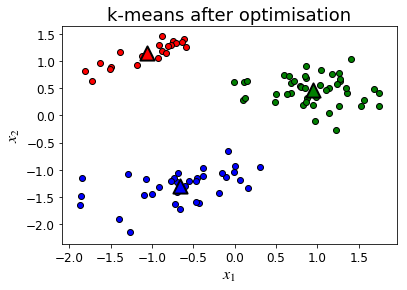

In [4]:
for idx, mu in enumerate(mus):
    plt.scatter(mu[0], mu[1], marker = '^', color = colors[idx], s = 200,
                edgecolor = 'black', zorder = 2, linewidth = '2')
    
    points_in_class = x[np.where(s[:, idx] == 1)[0], :]
    
    plt.scatter(points_in_class[:, 0], points_in_class[:, 1], marker = 'o',
                color = colors[idx], edgecolor = 'black', zorder = 1)
    
beautify_plot({"title":"k-means after optimisation", "x":"$x_1$", "y":"$x_2$"})
plt.show()

K-means reasonably picked for the memberships and cluster centers in this example. However, there are cases where k-means fails to produce the clustering we would intuitively expect:

<img src="clust_kmeans_pathology.svg" alt="Snow" style="width:90%; float: center; padding:0px">

In this example, the k-means algorithm produces a much different clustering to what we would intuitively expect. The edgemost points on either side of the elongated cluster are assigned to the blob-like clusters because this reduces the squared distances of these points from their cluster centers. This example reveals the general weakness of k-means in datasets where clusters are highly anisotropic, which is due to the fact that the distance metric weighs all directions equally, ignoring any interesting structure the clusters could have.

Another issue related to this pathological example is that cluster memberships are hard, meaning that points are assigned to one cluster or the other to minimise the cost function without mention of our degree of certainty about the assignment. A good clustering scheme should include a degree of certainty for our assignments, for example by working in terms of membership probabilities. We could transform $s_{nk}$ from a binary variable to a discrete probability distribution over $k$, expressing the probability that point $n$ belongs to the $k^{th}$ class which would then naturally express our certainty about the assignment. Compare this transition with the soft/hard descision boundaries transition we encountered in classification.

In the next section we will explore a clustering method which deals with anisotropic clustering and involves soft descision boundaries, called the mixture of gaussians model. For the moment however, we will stick with K-means and see how it may be applied to image compression and segmentation.

## K-means for image compression and segmentation

The goal of image compression is to take an image and encode it in a way such that the number of bits of the encoded version is smaller than that of the original. There are two options to go about this, namely lossless and lossy compression. In lossless compression we require that if we encode and then decode the image we retrieve the exact original. Lossy compression lifts this constraint by allowing the decoded image to differ from the original, thereby generally allowing further compression $-$ at the cost of quality loss. K-means offers a method for lossy compression, which works as follows:

1. Consider an image of $N$ pixels to be itself a dataset. The datapoints are then pixels in a $3$D space of (R, G, B) intensities (or $1$D for a grayscale image).

2. Perform K-means on this single-image dataset of pixels to get cluster centers $\boldsymbol{\mu}_k$ and memberships. Remember the cluster centers $\boldsymbol{\mu}_k$ are points in (R, G, B) space (or intensity space for grayscale).

3. Store memberships and the cluster centers. These make up the encoded image.

4. To decode the image, set the colour of each pixel to be the cluster center $\boldsymbol{\mu}_k$ to which this particular pixel belongs.

What is the size reduction of this method? An uncompressed colour image of $N$ pixels requires $24N$ bits ($8$ bits for each colour channel). The K-means encoding of this image involves the class membership of each pixel, which requires $N$log$_2K$ bits (log$_2K$ bits for each pixel) plus the cluster centers, which require $24K$ bits ($24$ bits for each cluster in RGB form). The total number of bits in the compressed image is therefore $24K + \text{log}_2K$ as opposed to $24N$. A colour image with $N = 1920 \times 1080 = 2073600$ pixels requires $49766400$ bits. Using K-means with $K = 2, 5, 20$ it can be compressed down to $2073648$, $4814870$ and $8962430$ bits respectively, with corresponding compression ratios of $4.16\%$, $9.67\%$ and $18.0\%$

We'll now apply this compression scheme to a grayscale and a colour image to see what the decompressed images look like, starting by showing the originals

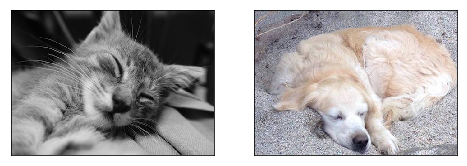

In [5]:
plt.figure(figsize = (8, 8))
plt.subplot(121)
cat = plt.imread('sleepy_cat.jpg')
plt.imshow(cat, origin = 'upper')
remove_axes()

plt.subplot(122)
dog = plt.imread('sleepy_dog.jpg')
plt.imshow(dog, origin = 'upper')
remove_axes()
plt.show()

For convenience, we will also write an implementation of k-means in a function, which performs the whole optimisation process. Cluster memberships are initialised randomly within function and the initial cluster centers are chosen manually and passed to the function by the user.

In [6]:
def k_means(x, K, max_steps, mu_init):
    
    N, D = x.shape # N: number of datapoints, D: number of input dimensions
    mu = mu_init.copy() # copy cluster centers to avoid mutation

    s = np.zeros(shape = (N, K)) # set all membership indices to 0
    memberships = np.random.choice(np.arange(0, K), N) # randomly choose a cluster for each point
    s[np.arange(s.shape[0]), memberships] = 1 # set the 1-entries according to the random sample
    
    x_stacked = np.stack([x]*K, axis = 1) # stack K copies of x to do calculation for each cluster
    losses = [np.sum(s*np.sum((x_stacked - mu)**2, axis = 2))] # array to store costs, containing 1st cost
    converged = False
    
    for i in range(max_steps):

        mus = (s.T).dot(x) # compute K centers in one go
        N_k = s.sum(axis = 0).reshape((-1, 1)) # number of members of cluster k
        mus[np.where(N_k >= 1)[0], :] /= N_k[np.where(N_k >= 1)[0]] # distance of each point from each cluster mean

        distances = np.sum((x_stacked - mus)**2, axis = 2) # find which cluster mean is closest to each point
        min_idx = np.argmin(distances, axis = 1)
        s_prev = s.copy()
        s = np.zeros_like(s)
        s[np.arange(s.shape[0]), min_idx] = 1

        losses.append(np.sum(s*np.sum((x_stacked - mus)**2, axis = 2)))
        
        if np.prod(np.argmax(s, axis = 1) == np.argmax(s_prev, axis = 1)):
            break
            
    return s, mus, losses

Using ```k_means``` we can easily perform the optimisation process and obtain the cluster memberships ```s``` and centers ```mus```. To obtain the decoded image we loop over $K$, and set the colour of every pixel of a given cluster to be the center of that cluster ```mu_dog[k]``` (or ```mu_cat[k]```).

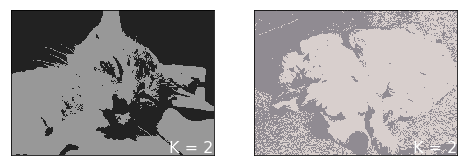

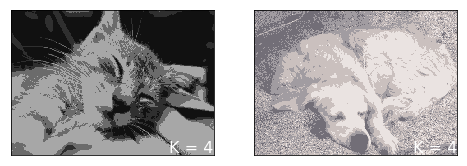

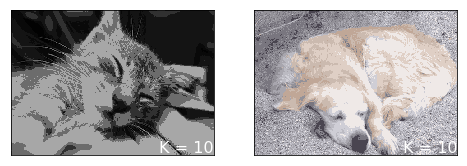

In [7]:
flat_dog, flat_cat = dog.reshape((-1, 3)), cat.reshape((-1, 1))

for K in [2, 4, 10]:
    s_dog, mu_dog, losses_dog = k_means(flat_dog, K, 10, np.random.rand(K, 1)*256)
    s_cat, mu_cat, losses_cat = k_means(flat_cat, K, 10, np.random.rand(K, 1)*256)
    
    K_colored_dog = flat_dog.copy()
    K_colored_cat = flat_cat.copy()
    
    for k in range(K):
        K_colored_dog[np.where(np.argmax(s_dog, axis = -1) == k)[0], :] = mu_dog[k]
        K_colored_cat[np.where(np.argmax(s_cat, axis = -1) == k)[0], :] = mu_cat[k]

    K_colored_dog = K_colored_dog.reshape(dog.shape)
    K_colored_cat = K_colored_cat.reshape(cat.shape)
    
    plt.figure(figsize = (8, 8))
    plt.subplot(121)
    plt.imshow(K_colored_cat, origin = 'upper')
    plt.text(450, 322, s = 'K = {}'.format(K), color = 'white', fontsize = 16,
             horizontalalignment = 'right', verticalalignment = 'bottom')
    remove_axes()

    plt.subplot(122)
    plt.imshow(K_colored_dog, origin = 'upper')
    plt.text(450, 322, s = 'K = {}'.format(K), color = 'white', fontsize = 16,
             horizontalalignment = 'right', verticalalignment = 'bottom')
    remove_axes()
    
    plt.show()

As more colours are added, the level of detail in the image progressively resembles the original. Note also how increasing $K$ increases the number of distinct colours in the dog picture and the number of different shades in the cat picture. It is also worthwhile to stress that pixels are clustered according to their distance in intensity space and not according to their proximity in the picture itself. Nearby pixels often have correlated colours when they belong to the same object however so k-means will cluster them together preserving the rough shape of the object, although clustering is carried out strictly in intensity space.

The colour correlation between different pixels points to another application of k-means, namely image segmentation. Here the objective is to divide the image in different regions which belong to the same object. K-means can achieve this by grouping pixels of similar colours together, presuming that pixels belonging to a certain object will have similar colours which will be clustered together. In the example below we apply this k-means to some Google Street View images of Cambridge.

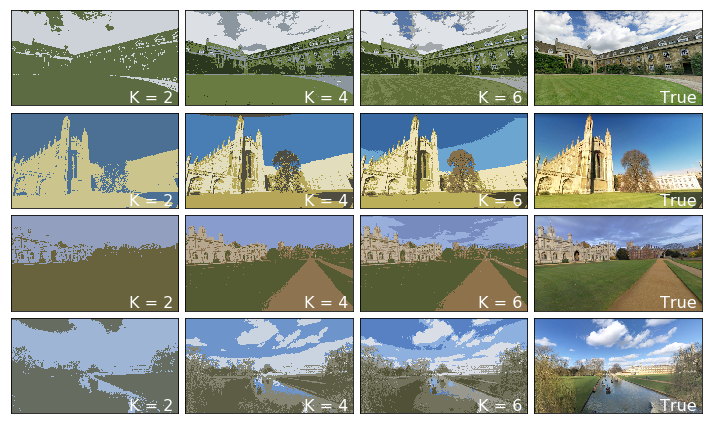

In [8]:
plt.figure(figsize = (10, 6))
for i in range(4):
    
    picture = plt.imread('{}.png'.format(str(i).zfill(3)))
    flat_pic = picture.reshape((-1, 3))
    
    for j, K in enumerate([2, 4, 6]):
        plt.subplot(4, 4, 4*i + j + 1)

        s_pic, mu_pic, losses_pic = k_means(flat_pic, K, 10, np.random.rand(K, 1)*256)
        pic_colors = [np.mean(flat_pic[np.where(np.argmax(s_pic, axis = -1) == k)], axis = 0) for k in np.arange(K)]
        K_colored_pic = flat_pic.copy()

        for k in range(K):
            K_colored_pic[np.where(np.argmax(s_pic, axis = -1) == k)[0], :] = pic_colors[k]

        K_colored_pic = K_colored_pic.reshape(picture.shape)
        plt.imshow(K_colored_pic, origin = 'upper')
        plt.text(720, 410, s = 'K = {} '.format(K), color = 'white', fontsize = 16,
                 horizontalalignment = 'right', verticalalignment = 'bottom')
        remove_axes()

    plt.subplot(4, 4, 4*(i+1))
    plt.imshow(picture, origin = 'upper')
    plt.text(720, 410, s = 'True ', color = 'white', fontsize = 16,
             horizontalalignment = 'right', verticalalignment = 'bottom')
    remove_axes()

plt.tight_layout(w_pad = 0, h_pad = 0)
plt.show()

The image could then be partitioned into areas different colours. Clearly this method will perform quite poorly in situations where a single object contains multiple and/or different colours. In such cases, the average colours (cluster centers) may be poor representations of the multiple colours appearing in the images if the value of $K$ is small, or the depicted object may be falsely partitioned in several different patches if $K$ is larger.

<img src="clust_kmeans_fail_ex.svg" alt="Snow" style="width:100%; float: center; padding:0px">

K-means may perform quite poorly and is not a reliable image segmentation method by itself. It may howevery be used as a preprocessing stage before applying a more complicated segmentation model to the image.